## Import Packages

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #随机森林模型
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

## Read File

In [7]:
data = pd.read_csv("CW_project4.txt", sep=" ", header=None)
data = data.drop(columns=6, axis=1)
data = data.rename(columns={7:6})


## Data Exploration 

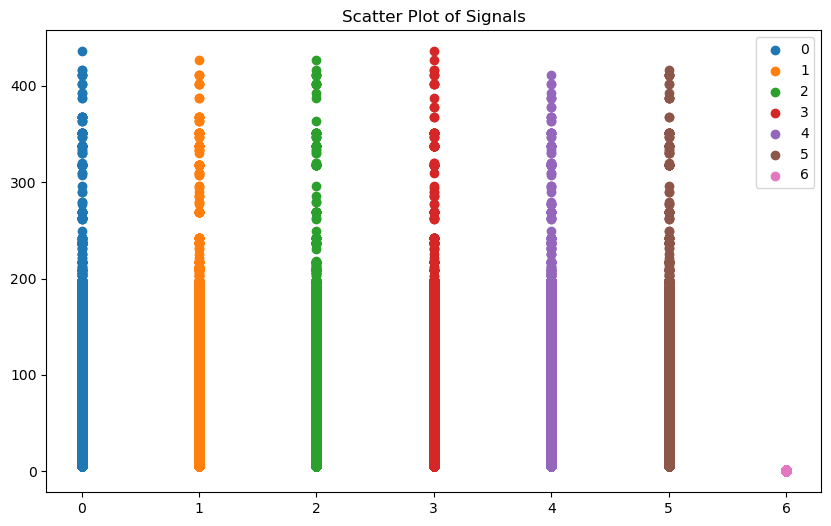

In [8]:
plt.figure(figsize=(10, 6))
for col in data.columns:
    plt.scatter([col] * len(data), data[col], label=col)

plt.legend()
plt.title("Scatter Plot of Signals")
plt.show()



## Use isolation forest to remove outliers

In [9]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
original_length = len(X)

IF = IsolationForest(contamination=0.05)
outliers = IF.fit_predict(X)

X = X[outliers != -1]
y = y[outliers != -1]

new_length = len(X)

removed_data_count = original_length - new_length

print(f"{removed_data_count} data has been removed")



50000 data has been removed


## Use a DNN model plus k-fold validation(k = 10) to train model

Epoch 1/2
    8/11875 [..............................] - ETA: 1:33 - loss: 2.9732 - accuracy: 0.5117 

2023-09-06 23:39:37.047207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11870/11875 [============================>.] - ETA: 0s - loss: 158.6790 - accuracy: 0.7549

2023-09-06 23:40:37.938291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11875/11875 [==============================] - 94s 8ms/step - loss: 158.7568 - accuracy: 0.7550 - val_loss: 564.4833 - val_accuracy: 0.7809
Epoch 2/2
11875/11875 [==============================] - 94s 8ms/step - loss: 1200.6632 - accuracy: 0.7948 - val_loss: 1783.2412 - val_accuracy: 0.7987


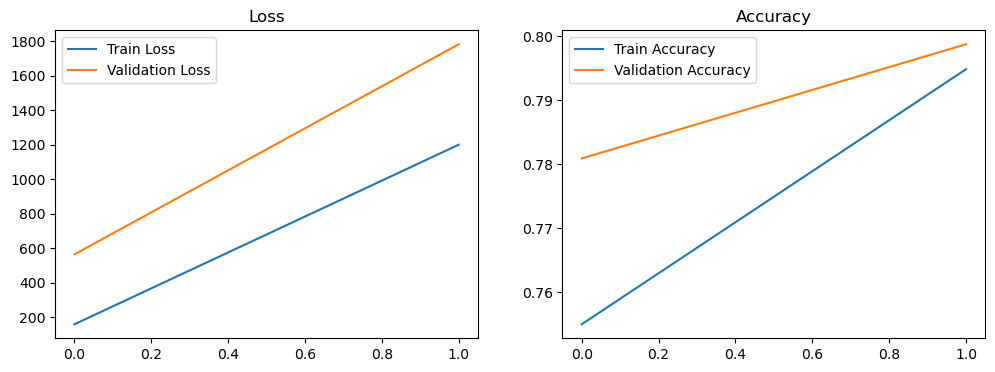

   94/11875 [..............................] - ETA: 19s

2023-09-06 23:42:44.572990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11875/11875 [==============================] - 17s 1ms/step
Epoch 1/2
    8/11875 [..............................] - ETA: 1:29 - loss: 3.9706 - accuracy: 0.5195    

2023-09-06 23:43:10.262631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11872/11875 [============================>.] - ETA: 0s - loss: 143.1649 - accuracy: 0.7385

2023-09-06 23:44:11.381095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11875/11875 [==============================] - 94s 8ms/step - loss: 143.3001 - accuracy: 0.7385 - val_loss: 1262.1099 - val_accuracy: 0.6424
Epoch 2/2
11875/11875 [==============================] - 94s 8ms/step - loss: 1149.3578 - accuracy: 0.7622 - val_loss: 5358.4976 - val_accuracy: 0.6577


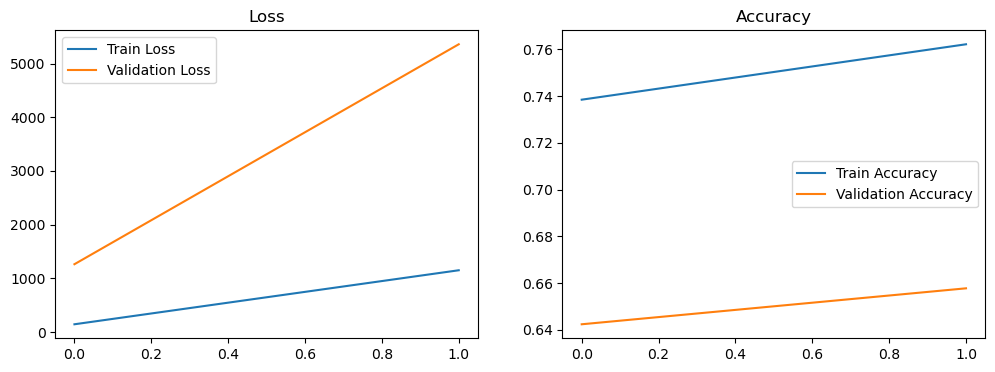

   96/11875 [..............................] - ETA: 18s

2023-09-06 23:46:17.812651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11875/11875 [==============================] - 17s 1ms/step
Mean validation accuracy: 0.7282


2023-09-06 23:46:36.536792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 0.6573
  98/5938 [..............................] - ETA: 9s

2023-09-06 23:46:54.764885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5938/5938 [==============================] - 9s 1ms/step


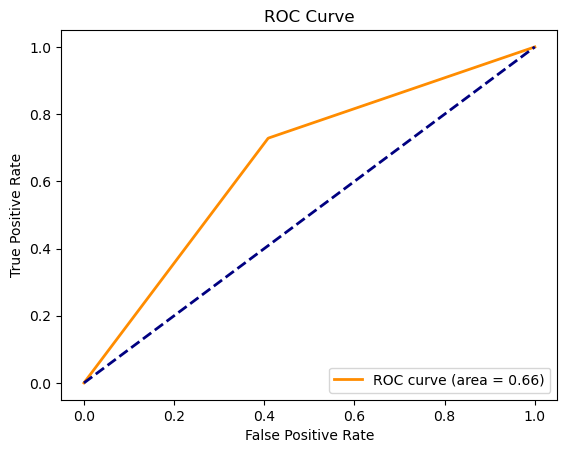

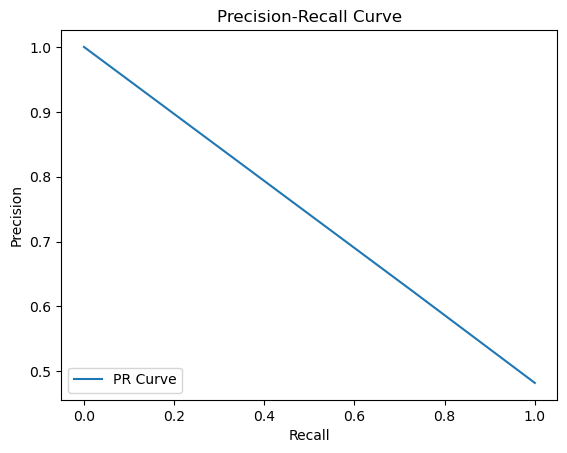

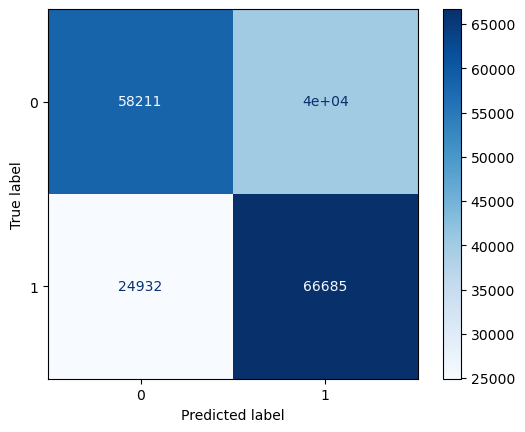

              precision    recall  f1-score   support

  background       0.70      0.59      0.64     98383
      signal       0.62      0.73      0.67     91617

    accuracy                           0.66    190000
   macro avg       0.66      0.66      0.66    190000
weighted avg       0.66      0.66      0.66    190000


In [10]:
# 创建k-fold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy = []  # 用于存储每次验证的准确率
all_y_val = []  # 存储所有验证的真实标签
all_y_pred_val = []  # 存储所有验证的预测值

# 使用k-fold进行十次循环
for train_index, val_index in kf.split(X, y):
    # 为当前循环划分训练集和验证集
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # 创建一个Sequential模型，使用多个Dense层
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(6,)), # 第一层，256个神经元，ReLU激活函数，输入层
        layers.Dense(128, activation='relu'), # 第二层，128个神经元，ReLU激活函数
        layers.Dense(64, activation='relu'),  # 第三层，64个神经元，ReLU激活函数
        layers.Dense(1, activation='sigmoid') # 输出层，1个神经元，sigmoid激活函数用于二分类
    ])
    
    # 编译模型，使用Adam优化器，二元交叉熵作为损失函数，准确率作为评估指标
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 训练模型，使用X_train和y_train，进行10个周期，批量大小为32，同时使用验证数据X_val和y_val
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # 绘制损失和准确率曲线
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

    # 使用模型进行预测
    y_pred_val = model.predict(X_val)
    all_y_val.extend(y_val)
    all_y_pred_val.extend(y_pred_val)
    accuracy.append(history.history['val_accuracy'][-1])

# 计算平均验证准确率
print(f"Mean validation accuracy: {sum(accuracy)/len(accuracy):.4f}")

# 使用所有的验证数据进行评估并绘制ROC、PR曲线和混淆矩阵
all_y_val = np.array(all_y_val)
all_y_pred_val = np.array(all_y_pred_val).ravel()

# ROC曲线
fpr, tpr, thresholds = roc_curve(all_y_val, all_y_pred_val)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(all_y_val, all_y_pred_val)
plt.figure()
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 混淆矩阵
matrix = confusion_matrix(all_y_val, np.round(all_y_pred_val))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 分类报告
y_pred_class = np.round(all_y_pred_val)
report = classification_report(all_y_val, y_pred_class, target_names=["background", "signal"])
print(report)

In [ ]:

from sklearn.preprocessing import MinMaxScaler
# 读取文件
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# 随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=0, verbose=2, n_jobs=4)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, preds)
print("准确率：", accuracy)

# 打印分类报告，包括精确度、召回率、F1分数等
report = classification_report(y_test, preds)
print("分类报告：\n", report)

# 计算 Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)

# 计算 ROC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# 画 PR 曲线
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# 画 ROC 曲线
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#计算混淆矩阵
conf_matrix = confusion_matrix(y_test, preds)

# 画混淆矩阵
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ["Background", "Signal"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.3s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
